# 夏秋雨
## 2024112200
# 无人机仿真

# 请务必阅读README，大部分公式和讲解都在README之中
# 请务必阅读README，大部分公式和讲解都在README之中
# 请务必阅读README，大部分公式和讲解都在README之中

In [1]:
import gymnasium as gym

In [2]:
import gym_env
env = gym.make("myQuadrotor")

In [3]:
from stable_baselines3 import SAC
import torch

# 使用SAC模型
# 该模型可以处理连续动作空间
# 详情见README

# 设置训练id以及初始化模型

In [4]:
run_id = "20250627t7"

model = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    device = "cuda" if torch.cuda.is_available() else "cpu",
    tensorboard_log="./logs/" + run_id
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


# 使用Tensorboard来记录运行的奖励曲线随迭代次数的变化

In [5]:
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.logger import configure
logger = configure("./logs/" + run_id, ["stdout", "tensorboard"])
model.set_logger(logger)

# 记录奖励
eval_callback = EvalCallback(
    env,
    eval_freq=1000,  
    n_eval_episodes=5,
    log_path="./logs/" + run_id,
    verbose=1
)
model.learn(total_timesteps=30000, callback=eval_callback)

Logging to ./logs/20250627t7


D:\chongzhuang\huinaibingLinux\python_code\bigHomeWork\.venv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float64, actual type: float32
  logger.warn(
D:\chongzhuang\huinaibingLinux\python_code\bigHomeWork\.venv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float64, actual type: float32
  logger.warn(
D:\chongzhuang\huinaibingLinux\python_code\bigHomeWork\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1000, episode_reward=-688.74 +/- 0.00
Episode length: 1751.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1.75e+03 |
|    mean_reward     | -689     |
| time/              |          |
|    total_timesteps | 1000     |
| train/             |          |
|    actor_loss      | -12.2    |
|    critic_loss     | 612      |
|    ent_coef        | 0.764    |
|    ent_coef_loss   | -1.81    |
|    learning_rate   | 0.0003   |
|    n_updates       | 899      |
---------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-427.00 +/- 0.00
Episode length: 500.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 500      |
|    mean_reward     | -427     |
| time/              |          |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | -18.9    |
|    critic_loss     | 2.4      |
|    ent_coef    

# 查看reward曲线
# 终端运行: tensorboard --logdir ./logs/run_id
# 浏览器访问: http://localhost:6006/

In [6]:
import simulator_config.environment_cfg as env_cfg
import simulator_config.quadrotor_cfg as quad_cfg

def save_cfg(path):
    with open(path, "w") as f:
        f.write(str(env_cfg.environment_cfg))
        f.write("\n")
        f.write(str(env_cfg.environment_init_cfg))
        f.write("\n")
        f.write(str(env_cfg.environment_reward_cfg))
        f.write("\n")
        f.write(str(quad_cfg.quadrotor_cfg))
        f.write("\n")

# 保存模型，以及模型参数

In [7]:
model.save("models/"+run_id+"/SAC.model")
save_cfg("models/"+run_id+"/SAC.config")

D:\chongzhuang\huinaibingLinux\python_code\bigHomeWork\.venv\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\20250627t7' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [8]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time

# 可视化无人机飞行路径
# 粉色为无人机飞行路径
# 蓝色为目标点

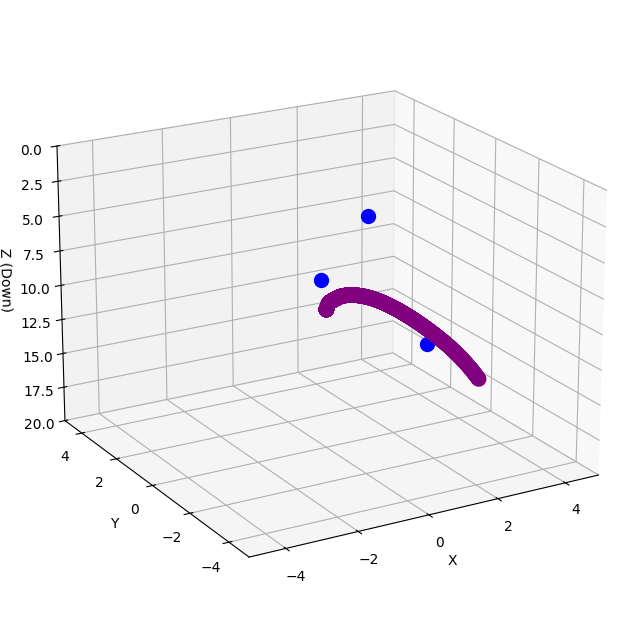

KeyboardInterrupt: 

In [9]:
load_model = SAC.load("models/"+run_id+"/SAC.model")

while True:
    time.sleep(0.5)
    
    obs, _ = env.reset()
    xs = []
    ys = []
    zs = []
    for _ in range(100000):
        action, _ = load_model.predict(obs)
        obs, _, done, truncate, _ = env.step(action)
        xs.append(obs[0])
        ys.append(obs[1])
        zs.append(obs[2])
        if done or truncate:
            break
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_zlim([20, 0])  
    # 这里的坐标系中，z轴指向地心
    # 这是航空专业喜欢用的坐标系，这里顺从这一规定
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z (Down)')  # 明确标注Z轴朝下
    
    ax.view_init(elev=20, azim=-120) 
    
    xx, yy = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10))
    zz = np.zeros_like(xx)
    
    
    ax.scatter(xs, ys, zs, s=100, c='purple')
    
    for i in env_cfg.environment_reward_cfg["rewardPoint"]:
        ax.scatter(i[0], i[1], i[2], s=100, c='blue')
    
    display.clear_output()
    plt.show()
    